# Synthetic Data Generation (Encoding/Decoding) using Auto Encoders
#### Creating new archtectures
Author: Gabriel Rodrigues Palma
Purpose: Encode and decode 5G data. Also, generate new dasets based on the autoencoders methods

# Packages

In [1]:
# visualisation modules
import matplotlib.pyplot as plt

# Data manipulation modules
import numpy as np
import pandas as pd

# Machine learning modules
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keract import get_activations, display_activations

# Deep learning modules
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import collections
# Testing GPU from MacOs
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


# Main functions

In [2]:
def transformCategoricalToBinary(data):
    '''Function created to transform categorical data to binary arrays'''
    reshapedData = np.array(data).reshape(len(data), -1)
    onehot_encoder = OneHotEncoder(sparse=False)
    onehot_encoded = onehot_encoder.fit_transform(reshapedData)    
    return(onehot_encoded)

def transformBinaryToCategorical(data, query):
    '''Function created to transform binary arrays data to categorical'''
    reshapedData = np.array(data).reshape(len(data), -1)
    onehot_encoder = OneHotEncoder(sparse=False)
    onehot_encoded = onehot_encoder.fit_transform(reshapedData)   
    query = query

    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(list(np.unique(reshapedData)))
    inverted = label_encoder.inverse_transform(list(np.argmax(query, axis=1))) 
    return(inverted)

def transformScaledToNonscaled(data, query):
    '''Function to obtain original data from scaled one'''
    scaler = MinMaxScaler(feature_range = (0,1))
    scaled_data = scaler.fit_transform(data) 
    if query.ndim ==1:
        query = query.reshape(1, len(query))
    else:
        query = query.reshape(len(query), -1)
    result = scaler.inverse_transform(query)

    return(result)

def getOriginalData(original_data, categorical_data, decoded_data):
    '''Function to obtain original data from decoded data'''
    decoded_numerical_data = decoded_data[:, 0:8]
    decoded_categorical_data = np.round(decoded_data[:, 8:42])
    numerical_data = transformScaledToNonscaled(data = original_data, 
                                                query = decoded_numerical_data)
    categorical_data = transformBinaryToCategorical(data = categorical_data, 
                                                    query = decoded_categorical_data)    
    result = np.hstack((numerical_data, categorical_data.reshape(len(categorical_data), 1)))

    return(result)

# Data pre processing

## Loading the data

In [4]:
original_data = pd.read_csv('../Data/5G-production-dataset/Download/Static/B_2019.12.16_13.40.04.csv')
encoded_text_data = transformCategoricalToBinary(original_data['PINGMAX'])
original_data.describe()

,Longitude,Latitude,Speed,CellID,RSRP,RSRQ,SNR,CQI,DL_bitrate,UL_bitrate,RAWCELLID
count,2.143000e+03,2.143000e+03,2143.0,2143.0,2143.000000,2143.000000,2143.000000,2143.00000,2143.000000,2143.000000,2143.0
mean,-8.394628e+00,5.188614e+01,0.0,11.0,-95.999067,-13.856276,3.717219,10.65329,50382.109193,141.879608,10805003.0
std,1.221694e-07,9.162706e-08,0.0,0.0,1.274617,2.239170,3.260739,1.91965,65620.519457,122.211380,0.0
min,-8.394628e+00,5.188614e+01,0.0,11.0,-104.000000,-19.000000,-7.000000,6.00000,0.000000,0.000000,10805003.0
25%,-8.394628e+00,5.188614e+01,0.0,11.0,-96.000000,-16.000000,2.000000,10.00000,3229.500000,44.000000,10805003.0
50%,-8.394628e+00,5.188614e+01,0.0,11.0,-96.000000,-14.000000,4.000000,11.00000,23853.000000,128.000000,10805003.0
75%,-8.394628e+00,5.188614e+01,0.0,11.0,-95.000000,-12.000000,6.000000,11.00000,61175.000000,215.000000,10805003.0
max,-8.394624e+00,5.188614e+01,0.0,11.0,-93.000000,-9.000000,15.000000,15.00000,302694.000000,1215.000000,10805003.0


## Data transformation

### Categorical to binary

In [5]:
encoded_text_data_test = transformCategoricalToBinary(np.unique(original_data['PINGMAX']))

In [6]:
encoded_text_data_test.shape

(34, 34)

### Binary to categorical

In [7]:
transformBinaryToCategorical(data = original_data['PINGMAX'], query = encoded_text_data_test[0:3, :])

array(['-', '100.0', '109.0'], dtype='<U5')

### Recreating original numerical data inputs

In [8]:
selected_data = original_data[['CellID','RSRP','RSRQ','SNR','CQI','DL_bitrate','UL_bitrate','RAWCELLID']]
scaler = MinMaxScaler(feature_range = (0,1))
scaler.fit(selected_data)
data_scaled = scaler.transform(selected_data)

In [9]:
pd.DataFrame(transformScaledToNonscaled(data=selected_data, query=data_scaled[0,:]))

,0,1,2,3,4,5,6,7
0,11.0,-103.0,-15.0,1.0,15.0,72.0,20.0,10805003.0


### Merging the numerical with categorical data

In [10]:
data = np.hstack((data_scaled, encoded_text_data))

## Creating the train and test data

In [11]:
X_train, X_test, y_train, y_test = train_test_split(data, data, test_size=0.3, random_state=42)

# Autoencoder implementation

In [24]:
# Start with a sequential model
autoencoder = Sequential()

# Add a dense layer with input the original image pixels and neurons the encoded representation
autoencoder.add(Dense(30, input_shape=(42, ), activation="relu"))
autoencoder.add(Dense(20, input_shape=(42, ), activation="relu"))
# Add an output layer with as many neurons as the orginal image pixels
autoencoder.add(Dense(42, activation = "sigmoid"))

# Compile your model with adadelta
autoencoder.compile(optimizer = 'adadelta', loss = 'binary_crossentropy', metrics = 'accuracy')

# Summarize your model structure
autoencoder.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 30)                1290      
                                                                 
 dense_4 (Dense)             (None, 20)                620       
                                                                 
 dense_5 (Dense)             (None, 42)                882       
                                                                 
Total params: 2,792
Trainable params: 2,792
Non-trainable params: 0
_________________________________________________________________


## training the model

In [13]:
autoencoder.fit(X_train, X_train, epochs=2000)

Epoch 1/2000


2022-06-23 11:23:39.675964: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-06-23 11:23:39.941188: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


47/47 [==============================] - 2s 6ms/step - loss: -0.3465 - accuracy: 0.0000e+00
Epoch 2/2000
47/47 [==============================] - 0s 5ms/step - loss: -0.3465 - accuracy: 0.0000e+00
Epoch 3/2000
47/47 [==============================] - 0s 6ms/step - loss: -0.3466 - accuracy: 0.0000e+00
Epoch 4/2000
47/47 [==============================] - 0s 5ms/step - loss: -0.3467 - accuracy: 0.0000e+00
Epoch 5/2000
47/47 [==============================] - 0s 5ms/step - loss: -0.3468 - accuracy: 0.0000e+00
Epoch 6/2000
47/47 [==============================] - 0s 5ms/step - loss: -0.3468 - accuracy: 0.0000e+00
Epoch 7/2000
47/47 [==============================] - 0s 5ms/step - loss: -0.3469 - accuracy: 0.0000e+00
Epoch 8/2000
47/47 [==============================] - 0s 5ms/step - loss: -0.3470 - accuracy: 0.0000e+00
Epoch 9/2000
47/47 [==============================] - 0s 5ms/step - loss: -0.3471 - accuracy: 0.0000e+00
Epoch 10/2000
47/47 [==============================] - 0s 5ms/step -

## Autoencoder performance

### Accuracy and loss function

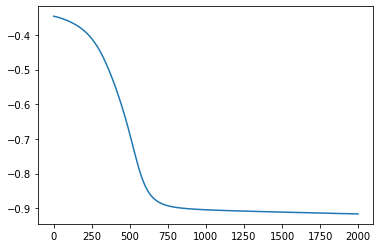

In [14]:
autoencoder_accuracy = pd.DataFrame(autoencoder.history.history['accuracy'])
autoencoder_loss = pd.DataFrame(autoencoder.history.history['loss'])
plt.plot(autoencoder_loss)
plt.show()

### Reproducing data

In [15]:
X_train.shape

(1500, 42)

In [16]:
# Build your encoder by using the first layer of your autoencoder
encoder = Sequential()
encoder.add(autoencoder.layers[0])

# Encode the noisy images and show the encodings for your favorite number [0-9]
encodings = encoder.predict(X_train)
#show_encodings(encodings, number = 1)
# Predict on the noisy images with your autoencoder
decoded_data = autoencoder.predict(X_train)

47/47 [==============================] - 0s 2ms/step


2022-06-23 11:33:27.579915: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-23 11:33:27.694530: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [17]:
encoded_data = encodings

In [18]:
pd.DataFrame(np.round(decoded_data[:,8:42]))

,0,1,2,3,4,5,6,7,8,9,...,24,25,26,27,28,29,30,31,32,33
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1496,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1497,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1498,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Autoencoder illustration 

## Original csv

In [19]:
original_csv = getOriginalData(original_data = selected_data, 
                              categorical_data = original_data['PINGMAX'], 
                              decoded_data = X_train)
original_csv = pd.DataFrame(original_csv, 
             columns = ['CellID','RSRP','RSRQ','SNR','CQI','DL_bitrate',
                        'UL_bitrate','RAWCELLID', 'PINGMAX'])
original_csv

,CellID,RSRP,RSRQ,SNR,CQI,DL_bitrate,UL_bitrate,RAWCELLID,PINGMAX
0,11.0,-95.99999999999999,-17.0,2.9999999999999996,8.0,61756.0,256.0,10805003.0,-
1,11.0,-97.0,-16.0,4.999999999999999,8.0,25025.0,145.0,10805003.0,-
2,11.0,-95.99999999999999,-12.000000000000002,7.0,10.000000000000002,6614.999999999999,27.999999999999996,10805003.0,79.0
3,11.0,-95.0,-15.0,4.0,11.0,36005.0,149.0,10805003.0,-
4,11.0,-95.0,-16.0,2.9999999999999996,10.000000000000002,36367.0,136.0,10805003.0,-
...,...,...,...,...,...,...,...,...,...
1495,11.0,-95.99999999999999,-15.0,1.9999999999999993,11.0,195371.0,281.0,10805003.0,-
1496,11.0,-95.99999999999999,-16.0,8.000000000000002,8.0,0.0,0.0,10805003.0,76.0
1497,11.0,-95.99999999999999,-12.000000000000002,4.999999999999999,10.000000000000002,31222.000000000004,138.0,10805003.0,-
1498,11.0,-95.0,-12.000000000000002,1.0000000000000002,11.0,10180.0,125.0,10805003.0,-


In [ ]:
np.unique(original_csv['PINGMAX'])

array(['-', '100.0', '109.0', '112.0', '114.0', '123.0', '128.0', '133.0',
       '182.0', '213.0', '278.0', '503.0', '74.0', '75.0', '76.0', '77.0',
       '78.0', '79.0', '80.0', '81.0', '82.0', '83.0', '84.0', '85.0',
       '87.0', '90.0', '93.0', '94.0'], dtype=object)

## Encoded csv

In [ ]:
pd.DataFrame(encoded_data, 
             columns = ['Encode%s'%(number) for number in range(30)])

,Encode0,Encode1,Encode2,Encode3,Encode4,Encode5,Encode6,Encode7,Encode8,Encode9,...,Encode20,Encode21,Encode22,Encode23,Encode24,Encode25,Encode26,Encode27,Encode28,Encode29
0,0.0,0.0,0.0,1.306441,0.0,1.218581,1.803766,0.0,0.425435,0.000000,...,0.000000,1.149578,1.522574,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
1,0.0,0.0,0.0,1.373992,0.0,1.195018,1.798741,0.0,0.378539,0.000000,...,0.000000,1.121441,1.535888,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
2,0.0,0.0,0.0,1.004606,0.0,1.565732,1.740201,0.0,0.000000,0.000000,...,0.263656,0.769367,1.602276,0.007193,0.0,0.0,0.0,0.000000,0.0,0.0
3,0.0,0.0,0.0,1.544879,0.0,1.468195,1.961122,0.0,0.424896,0.000000,...,0.000000,1.285989,1.728796,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
4,0.0,0.0,0.0,1.475100,0.0,1.378618,1.886142,0.0,0.425523,0.000000,...,0.000000,1.239639,1.642277,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,0.0,0.0,0.0,1.331666,0.0,1.504272,1.945214,0.0,0.451010,0.000000,...,0.000000,1.256096,1.774857,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
1496,0.0,0.0,0.0,1.176036,0.0,0.926068,1.619027,0.0,0.000000,0.226761,...,0.145742,0.904949,1.373782,0.000000,0.0,0.0,0.0,0.127289,0.0,0.0
1497,0.0,0.0,0.0,1.630318,0.0,1.416190,2.016431,0.0,0.354735,0.000000,...,0.000000,1.237377,1.816929,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
1498,0.0,0.0,0.0,1.675211,0.0,1.431287,1.971432,0.0,0.404136,0.000000,...,0.000000,1.269675,1.784693,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0


## Decoded csv

In [ ]:
# Use it: CelllD, PINGMAX
# RAWCELLID remove


In [ ]:
decoded_csv = getOriginalData(original_data = selected_data, 
                              categorical_data = original_data['PINGMAX'], 
                              decoded_data = decoded_data)
decoded_csv = pd.DataFrame(decoded_csv, 
             columns = ['CellID','RSRP','RSRQ','SNR','CQI','DL_bitrate',
                        'UL_bitrate','RAWCELLID', 'PINGMAX'])
decoded_csv

,CellID,RSRP,RSRQ,SNR,CQI,DL_bitrate,UL_bitrate,RAWCELLID,PINGMAX
0,11.023495,-93.030365,-11.472315,7.7280164,14.630027,79591.09,227.35223,10805003.0,-
1,11.023225,-93.030334,-11.483407,7.718739,14.633032,78400.69,230.7823,10805003.0,-
2,11.026933,-93.03769,-11.45104,7.8314295,14.57407,85956.625,235.61331,10805003.0,-
3,11.014798,-93.014565,-11.216191,8.069659,14.74902,70811.734,197.02092,10805003.0,-
4,11.017701,-93.01931,-11.3116665,7.9283323,14.709002,73963.59,207.75404,10805003.0,-
...,...,...,...,...,...,...,...,...,...
1495,11.015455,-93.015305,-11.222457,8.049203,14.734005,73409.086,197.74777,10805003.0,-
1496,11.0443735,-93.07906,-11.803291,7.208459,14.374618,93636.35,267.1588,10805003.0,-
1497,11.01385,-93.0133,-11.217461,8.118252,14.760455,68924.555,199.42638,10805003.0,-
1498,11.013871,-93.01305,-11.221476,8.102646,14.763847,68568.69,196.62988,10805003.0,-


In [ ]:
# Abstract is very important
# Important to know what is the problem 
# How your architecture solve the problem 
# Results 
# Compare with some baseline   
np.unique(decoded_csv['PINGMAX'])

array(['-'], dtype=object)

# Autoencoder visualisation

In [190]:
activations = get_activations(autoencoder, X_test[0:1])
subset = lambda d, *keys: [(key, d[key]) for key in d.keys() if key in set(keys)]
new_set = collections.OrderedDict(subset(activations, 'dense_input', 'dense_1', 'dense_2'))

In [206]:
#activations